In [ ]:
# default_exp engine.microscope

In [ ]:
%load_ext autoreload
%autoreload 2

# Microscope model

> Definition of the classes and functions we use to generate recordings given network outputs or simulations

In [ ]:
#export
from decode_fish.imports import *
import torch.nn as nn
from decode_fish.funcs.utils import *
from torch.jit import script
from typing import Union, List
import torch.nn.functional as F
from decode_fish.funcs.plotting import *
from decode_fish.engine.place_psfs import _place_psf, CudaPlaceROI
# import elasticdeform.torch as etorch

[autoreload of decode_fish.engine.place_psfs failed: Traceback (most recent call last):
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [ ]:
#export
class Microscope(nn.Module):
    """
    The Mircoscope module takes  5 vectors 'locations', 'x_os', 'y_os', 'z_os',
    'ints_3d' turns them into 3D data through the following steps:
    1) Apply continuous shifts to the PSF according to x_os, y_os, z_os
    2) Clamping the PSF (retaining only positive values)
    3) Normalize the PSF dividing it by it's max value
    6) Place point spread function according to locations  to
    generate 'x_sim'
    7) Multiplies x_sim with scale

    Args:
        psf (torch.nn.Module): Parametric PSF
        noise (torch.nn.Module): Camera noise model
        scale(float): Constant for scaling 
        
    Shape:
        -Input: locations: Tuple(torch.Tensor)
                x_os_val: (N_emitters,)
                y_os_val: (N_emitters,)
                z_os_val: (N_emitters,)
                ints_val: (N_emitters,C)
                output_shape: Shape Tuple(BS, C, H, W, D)

        -Output: xsim: (BS, C, H, W, D)
    """


    def __init__(self, psf: torch.nn.Module=None, noise: Union[torch.nn.Module, None]=None, scale: float = 10000., norm='max', psf_noise=0, pos_noise_xy=0, pos_noise_z=0, slice_rec=False, ch_facs=None, ch_cols=None):

        super().__init__()
        self.psf = psf
        self.psf_init_vol = psf.psf_volume.detach().to('cuda')
        self.scale = scale
        self.noise = noise
        self.norm = norm
        
        self.psf_norm_init = 1.
        if slice_rec:
            if norm == 'sum':
                self.psf_norm_init = self.psf.psf_volume.detach().sum(2, keepdim=True).sum(3, keepdim=True).to('cuda')
            if norm == 'max':
                self.psf_norm_init = self.psf.psf_volume.detach().amax(2, keepdim=True).amax(3, keepdim=True).to('cuda')
        else:
            if norm == 'sum':
                self.psf_norm_init = self.psf.psf_volume.detach().sum().to('cuda')
            if norm == 'max':
                self.psf_norm_init = self.psf.psf_volume.detach().amax().to('cuda')        
        
        self.theta = self.noise.theta_scale * self.noise.theta_par
        
        self.psf_noise = psf_noise
        self.pos_noise_xy = pos_noise_xy
        self.pos_noise_z = pos_noise_z

        self.slice_rec = slice_rec
        self.psf_z_size = self.psf.psf_volume.shape[-3]
        self.ch_cols = ch_cols
        
        self.register_parameter(name='channel_shifts', param=self.noise.channel_shifts)
        self.ch_scale = 1. if ch_facs is None else torch.tensor(ch_facs).cuda()
        self.register_parameter(name='channel_facs', param=torch.nn.Parameter(torch.ones(len(self.channel_shifts))))
        self.ch_norm = self.channel_facs.sum().detach().cuda()
            
        self.register_parameter(name='theta_par', param=self.noise.theta_par)
        self.register_parameter(name='psf_vol', param=self.psf.psf_volume)
        
    def add_psf_noise(self, psf_stack):

        '''Gaussian noise'''
        noise = torch.distributions.Normal(loc=0, scale=self.psf_noise).sample(psf_stack.shape).to(psf_stack.device)
        noise *= torch.sqrt(psf_stack)
#         noise *= torch.rand(len(psf_stack), device='cuda')[:,None,None,None,None]
        return psf_stack + noise
    
        '''Individual elastic deformation for each PSF (to slow)'''
#         psf_deformed = torch.cat([etorch.deform_grid(psf, torch.distributions.Normal(loc=0, scale=self.psf_noise).sample([3,3,3,3]).to(psf_stack.device), order=3)[None] 
#                                   for psf in psf_stack[:,0]])
        '''Single deformation for all PSF in batch (kinda stupid)'''
#         psf_deformed = etorch.deform_grid(psf_stack[:,0], torch.distributions.Normal(loc=0, scale=self.psf_noise).sample([3,3,3,3]).to(psf_stack.device), axis=(1,2,3),order=3)
#         return psf_deformed[:,None]

    def add_pos_noise(self, x_os, y_os, z_os):
        
        # Hardcoded n_bits for now. 
        x_n = torch.distributions.Normal(loc=0, scale=self.pos_noise_xy).sample(x_os.shape).to(x_os.device).reshape(-1,4)
        x_n -= x_n.mean(-1, keepdim=True)
        x_os = x_os + x_n.reshape(-1)
        y_n = torch.distributions.Normal(loc=0, scale=self.pos_noise_xy).sample(y_os.shape).to(y_os.device).reshape(-1,4)
        y_n -= y_n.mean(-1, keepdim=True)
        y_os = y_os + y_n.reshape(-1)
        z_n = torch.distributions.Normal(loc=0, scale=self.pos_noise_z).sample(z_os.shape).to(z_os.device).reshape(-1,4)
        z_n -= z_n.mean(-1, keepdim=True)
        z_os = z_os + z_n.reshape(-1)
        
        return x_os, y_os, z_os

    def get_single_ch_inputs(self, locations, x_os_val, y_os_val, z_os_val, i_val, output_shape=None):
        
        ch_inds = i_val.nonzero(as_tuple=True)
        if ch_inds[1].max() > 0:
            shifts = self.channel_shifts - self.channel_shifts.mean(0)[None]

            x_os_ch = x_os_val[ch_inds[0]] + shifts[ch_inds[1], 0]
            y_os_ch = y_os_val[ch_inds[0]] + shifts[ch_inds[1], 1]
            z_os_ch = z_os_val[ch_inds[0]] + shifts[ch_inds[1], 2]

            i_val = i_val[ch_inds]
            
            locations = [l[ch_inds[0]] for l in locations]
            locations.insert(1,ch_inds[1])   
            
        return locations, x_os_ch, y_os_ch, z_os_ch, i_val, output_shape
    
    def get_psf_norm(self, c_inds = None, z_inds=None):
        
        if self.norm != 'max' and self.norm != 'sum':
            return 1.
        if not self.slice_rec:
            if self.norm == 'max': psf_norm = self.psf.psf_volume.max() 
            if self.norm == 'sum': psf_norm = torch.clamp_min(self.psf.psf_volume, 0).sum() 
            init = self.psf_norm_init     
        else:
            if self.norm == 'max':
                psf_norm = self.psf.psf_volume.amax(2, keepdim=True).amax(3, keepdim=True)
            if self.norm == 'sum':
                psf_norm = torch.clamp_min(self.psf.psf_volume, 0).sum(2, keepdim=True).sum(3, keepdim=True)
            if c_inds is not None:
                psf_norm = psf_norm[c_inds, z_inds][:,:,None,None]
                init = self.psf_norm_init[c_inds, z_inds][:,:,None,None]
            else:
                psf_norm = psf_norm[0,z_inds][:,None,None]
                init = self.psf_norm_init[0,z_inds][:,None,None]
  
        return psf_norm/init
        
    def forward(self, locations, x_os_ch, y_os_ch, z_os_ch, i_val, output_shape, ret_psfs=False, add_noise=False, add_pos_noise=False):
        
        if len(locations[0]):
            c_inds=torch.tensor(self.ch_cols)[locations[1]] if self.ch_cols is not None else None

            # Apply continuous shift
            if self.slice_rec and self.psf_z_size > 1:
                z_os_ch = torch.clamp(z_os_ch,-0.49999,0.49999) + 0.5 # transform to [0,1]
                z_scaled = z_os_ch * (self.psf_z_size - 2) # [0, z_size]
                z_inds = (z_scaled//1).type(torch.cuda.LongTensor) + 1
                z_os = -(z_scaled%1.) + 0.5

                if self.pos_noise_xy and add_pos_noise: 
                    x_os_ch, y_os_ch, z_os = self.add_pos_noise(x_os_ch, y_os_ch, z_os)

                psf = self.psf(x_os_ch, y_os_ch, z_os, z_inds, c_inds=c_inds)
#                 psf = psf[torch.arange(len(z_os_ch)),:,z_inds][:,:,None]
            else:
                if self.pos_noise_xy and add_noise: 
                    x_os_ch, y_os_ch, z_os_ch = self.add_pos_noise(x_os_ch, y_os_ch, z_os_ch)
                psf = self.psf(x_os_ch, y_os_ch, z_os_ch, c_inds=c_inds)
                z_inds = None
                
            torch.clamp_min_(psf,0)
            psf = psf/self.get_psf_norm(c_inds, z_inds)
            
            if self.psf_noise and add_noise: 
                psf = self.add_psf_noise(psf)
                
            # applying intenseties
#             tot_intensity = torch.clamp_min(i_val, 0)  * self.channel_facs[locations[1]]
            tot_intensity = torch.clamp_min(i_val, 0)  * (self.ch_scale * self.channel_facs)[locations[1]] * (self.ch_norm/self.channel_facs.sum())
    
            psf = psf * tot_intensity[:,None,None,None,None]
            
            if ret_psfs:
                return self.scale * psf
            
            # place psf according to locations
            xsim = place_psf(locations, psf, output_shape)
            
            # scale (not learnable)
            xsim = self.scale * xsim
            
            return xsim
        
        else:
            
            return torch.zeros(output_shape).cuda()

In [ ]:
#export
def place_psf(locations, psf_volume, output_shape):
    """
    Places point spread functions (psf_volume) in to corresponding locations.

    Args:
        locations: tuple with the 5D voxel coordinates
        psf_volume: torch.Tensor
        output_shape: Shape Tuple(BS, C, H, W, D) 

    Returns:
        placed_psf: torch.Tensor with shape (BS, C, H, W, D)
    """

    b, c, z, y, x = locations
    # Deprecated python loop
#     placed_psf = _place_psf(psf_volume, b, c, z, y, x, torch.tensor(output_shape))
    
    # New fancy cuda loop
    N_psfs, _, psf_s_z, psf_s_y, psf_s_x = psf_volume.shape   
    placed_psf = CudaPlaceROI.apply(psf_volume[:,0], output_shape[0], output_shape[1], output_shape[2], output_shape[3], output_shape[4], N_psfs, psf_s_z, psf_s_y, psf_s_x, b, c, z-psf_s_z//2, y-psf_s_y//2, x-psf_s_x//2)
    
    assert placed_psf.shape == output_shape
    return placed_psf

def extract_psf_roi(locations, x_vol, roi_shape):
    """
    Extract ROIs from a given volume
    """
    
    batch, ch, z, y, x = locations 
    rois = _extract_psf_roi(x_vol, batch, ch, z, y, x, roi_shape)
    
    return rois

from scipy.spatial.distance import cdist
from scipy.spatial import KDTree

def get_roi_filt_inds(batch, ch, z, y, x, psf_shape, vol_shape, min_dist=None, slice_rec=False):
    """
    Filter locations that are used for gen. model training.
    Returns remaining indices.
    """
    
    inds = torch.arange(len(x))
    
    if min_dist:
        # scale z if slice_rec ?? 
        bczyx = np.stack([cpu(batch)*1000,cpu(ch)*1000,cpu(z),cpu(y),cpu(x)]).T
        tree = KDTree(bczyx)
        pairs = tree.query_pairs(r=min_dist, output_type='ndarray')
        pair_inds = np.unique(pairs.reshape(-1))
        
    psf_d, psf_h, psf_w = psf_shape[-3:]
    vol_d, vol_h, vol_w = vol_shape[-3:]
    # Filter locs at the edges
    cond = (x > psf_w//2) & (x < vol_w - psf_w//2)
    cond*= (y > psf_h//2) & (y < vol_h - psf_h//2)
    if not slice_rec:
        cond*= (z > psf_d//2) & (z < vol_d - psf_d)   
        
    if min_dist:
        return np.setdiff1d(inds[cond], pair_inds, assume_unique=True)
    else:
        return inds[cond]
    
def mic_inp_apply_inds(locations, x_os_ch, y_os_ch, z_os_ch, i_val, output_shape, inds):
    
    locations = [l[inds] for l in locations]
    return locations, x_os_ch[inds], y_os_ch[inds], z_os_ch[inds], i_val[inds], output_shape

In [ ]:
#export
@script
def _extract_psf_roi(x_vol, batch, ch, z, y, x, roi_shape):
    
    """
    Extract rois. We assume that border conditions are dealt with already. 
    
    """

    psf_b, psf_ch, psf_d, psf_h, psf_w = roi_shape[0], roi_shape[1], roi_shape[2], roi_shape[3], roi_shape[4]
    roi_vol = torch.empty(psf_b, psf_ch, psf_d, psf_h, psf_w).to(x_vol.device)    
    pad_zyx = [psf_d//2, psf_h//2, psf_w//2]
    
    z_l = z - pad_zyx[0]
    y_l = y - pad_zyx[1]
    x_l = x - pad_zyx[2]
    
    z_h = z + pad_zyx[0] + 1
    y_h = y + pad_zyx[1] + 1
    x_h = x + pad_zyx[2] + 1
    
    for idx in range(x.shape[0]):

        roi_vol[idx] = x_vol[batch[idx], ch[idx],
                         z_l[idx] : z_h[idx],
                         y_l[idx] : y_h[idx],
                         x_l[idx] : x_h[idx]]
        
    return roi_vol

In [ ]:
from decode_fish.engine.psf import LinearInterpolatedPSF
from decode_fish.engine.noise import sCMOS
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.file_io import get_gaussian_psf
from decode_fish.funcs.file_io import get_vol_psf
from decode_fish.funcs.output_trafo import sample_to_df

# psf = get_gaussian_psf([3,13,13],[.1,1.7,1.7], pred_z=True, n_cols=2).cuda()
psf = get_vol_psf('../figures/MF_psf2.tif', n_cols=2)

noise = sCMOS(channels=22)

# micro = Microscope(psf=psf, noise=noise, scale=100, norm='sum', sum_fac=psf.psf_volume.sum().item()).cuda()
micro = Microscope(psf=psf, noise=noise, scale=100, norm='sum',  psf_noise=0.0, pos_noise_xy=0.7, pos_noise_z=0.3, slice_rec=True).cuda()
micro.ch_cols = [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0]

In [ ]:
# cfg = OmegaConf.load('../config/experiment/MERFISH_mop_4a.yaml')
# from decode_fish.funcs.file_io import load_psf_noise_micro
# psf, noise, micro = load_psf_noise_micro(cfg)

In [ ]:
for name, p in micro.named_parameters():
    print(name, p.requires_grad)

channel_shifts True
channel_facs True
theta_par True
psf_vol True


In [ ]:
from decode_fish.funcs.exp_specific import *
bench_df, code_ref, targets = get_merfish_mop()

In [ ]:
point_process = PointProcessUniform(local_rate = torch.ones([3,7,48,48]).cuda()*.0001, int_conc=3, int_rate=1, int_loc=1, sim_iters=5, channels=22, n_bits=4, sim_z=True, codebook=torch.tensor(code_ref, dtype=torch.bool), int_option=2)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, codes = point_process.sample(from_code_book=True)
locations, x_os_ch, y_os_ch, z_os_ch, i_val, output_shape = micro.get_single_ch_inputs(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape)
# df = sample_to_df(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, codes, px_size_zyx=[1,1,1])

In [ ]:
psfs = micro(locations, x_os_ch, y_os_ch, z_os_ch, i_val, output_shape, add_noise=False, ret_psfs=True)

In [ ]:
xsim = micro(locations, x_os_ch, y_os_ch, z_os_ch, i_val, output_shape, add_noise=True, add_pos_noise=True)

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (49) < 2 * SM count (160) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [ ]:
np.mean([1.0440,  0.7444, -1.0476,  0.2227])

0.24087499999999998

In [ ]:
xsim2 = micro(locations, x_os_ch, y_os_ch, z_os_ch, i_val, output_shape, add_noise=False)

In [ ]:
filt_inds = get_roi_filt_inds(*locations, micro.psf.psf_volume.shape, xsim.shape, slice_rec=True, min_dist=10)
ch_out_inp = mic_inp_apply_inds(locations, x_os_ch, y_os_ch, z_os_ch, i_val, output_shape, filt_inds)
rois = extract_psf_roi(ch_out_inp[0], xsim, torch.tensor(psfs.shape))

In [ ]:
# %%timeit
# rois = extract_psf_roi(ch_out_inp[0], xsim, torch.tensor(psfs.shape))

(2, 11)


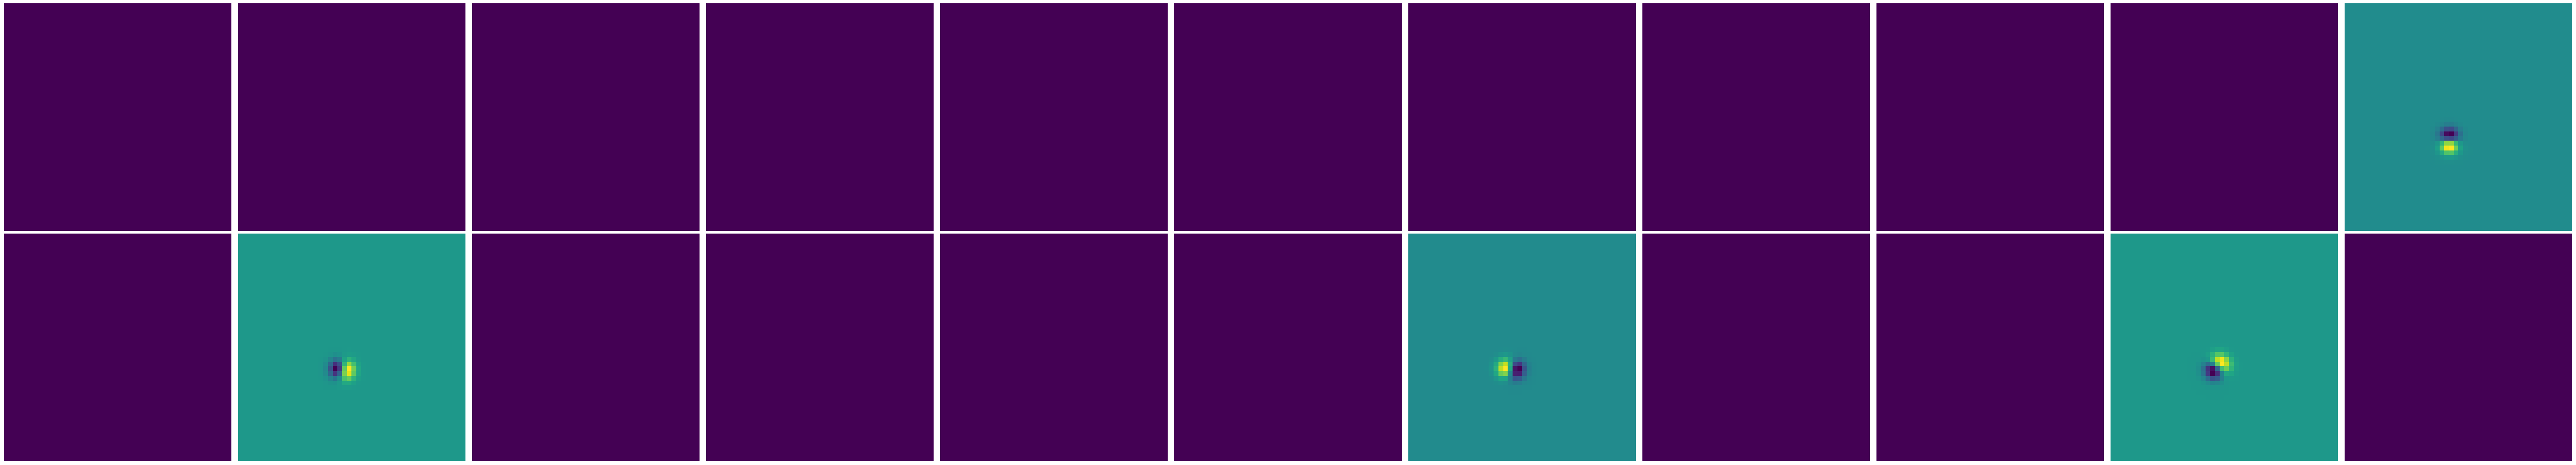

In [ ]:
_ = plot_channels(xsim[0]-xsim2[0],2, proj_func=np.sum)

(array([ 55., 145., 248., 216., 175.,  95.,  47.,  15.,   3.,   1.]),
 array([0.04329047, 0.1671234 , 0.29095635, 0.4147893 , 0.53862226,
        0.6624552 , 0.78628814, 0.9101211 , 1.033954  , 1.157787  ,
        1.2816199 ], dtype=float32),
 <BarContainer object of 10 artists>)

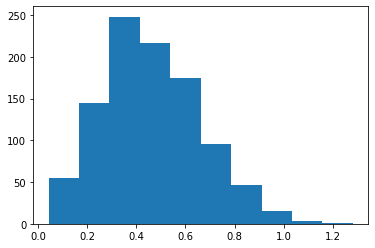

In [ ]:
plt.hist(cpu(torch.sqrt(torch.distributions.Normal(loc=0, scale=0.3).sample([1000])**2 +
torch.distributions.Normal(loc=0, scale=0.3).sample([1000])**2 +
torch.distributions.Normal(loc=0, scale=0.3).sample([1000])**2)))

### check that 2D Z reconstruction is correct.

In [ ]:
local_rate = torch.zeros([100,7,11,11]).cuda()
local_rate[:,0,5,5] = 1.

point_process = PointProcessUniform(local_rate =local_rate, int_conc=3, int_rate=1, sim_iters=1, int_loc=1, channels=22, n_bits=4, codebook=torch.tensor(code_ref)[:1], sim_z=True)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, codes = point_process.sample(from_code_book=True)
df = sample_to_df(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, codes, px_size_zyx=[1,1,1])

x_os_3d *= 0 
y_os_3d *= 0 
ints_3d *= 0 
ints_3d += 1
z_os_3d = torch.linspace(-0.7,0.7,100).cuda()

ch_inp = micro.get_single_ch_inputs(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape)

psf_s = micro(*ch_inp, add_noise=False, ret_psfs=True)

In [ ]:
plt.plot(cpu(psf_s)[::22,0,0,10,10])

In [ ]:
def get_micro_inp(res_dict, code_ref, p_si=None, n_bits=4, channels=16):

    res_dict['Samples_si'] = torch.where(torch.sigmoid(res_dict['logits']) > 0.0091, 1, 0)
    # remove dump inds. Wont get reconstructed. 
    locations = res_dict['Samples_si'][:,:-1].nonzero(as_tuple=True)

    xyzi_ix = [locations[0],locations[2],locations[3], locations[4]]
    x_os_3d = res_dict['xyzi_mu'][:,0][xyzi_ix]
    y_os_3d = res_dict['xyzi_mu'][:,1][xyzi_ix]
    z_os_3d = res_dict['xyzi_mu'][:,2][xyzi_ix]
    ints_3d = res_dict['xyzi_mu'][:,3][xyzi_ix]
    # output_shape  = res_dict['Samples_si'].shape
    ints_3d = ints_3d/n_bits+1

    ints_ret = ints_3d[:,None].repeat_interleave(channels, 1)
#     ch_bin = torch.zeros(ints_ret.shape).to(ints_ret.device)
#     ch_bin.scatter_(index=torch.tensor(code_inds).to(ints_ret.device)[locations[1]], dim=1, value=1)
    ch_bin = torch.tensor(code_ref)[locations[1]]
    ints_ret = ints_ret*ch_bin.to(ints_ret.device)

    output_shape  = res_dict['Samples_si'].shape
    output_shape  = torch.Size([output_shape[0],channels,output_shape[2],output_shape[3],output_shape[4]])

    return xyzi_ix, x_os_3d, y_os_3d, z_os_3d, ints_ret, output_shape

In [ ]:
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = get_micro_inp(res_dict, torch.tensor(code_ref), p_si=None, n_bits = 4, channels=22)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted index.ipynb.
